## Predicting if someone will make a default on their loan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import os
path_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path_list.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv


### Load Data

In [2]:
train_df = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv")
test_df = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv")
targets = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv")

In [3]:
train_df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [4]:
test_df.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [5]:
targets.head()

,id,risk_flag
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0


In [6]:
print(f"The training data set size: {train_df.shape}")
print(f"The test data set size: {test_df.shape}")

The training data set size: (252000, 13)
The test data set size: (28000, 12)


## EDA

In [7]:
train_df.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


**No NAN values!**

### Numerical Columns

In [9]:
# get numeric columns
train_num = train_df.select_dtypes(include=["int64"]).set_index("Id")
train_num.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,
1,1303834,23,3,3,13,0
2,7574516,40,10,9,13,0
3,3991815,66,4,4,10,0
4,6256451,41,2,2,12,1
5,5768871,47,11,3,14,1


In [10]:
def num_sub_plots_hist(df):
    """
    Input: numerical data
    Output: plots histograms of the features compared to the label
    """
    num_plots = len(df.columns)
    fig, axs = plt.subplots(num_plots, 1, figsize=(8,3*num_plots))
    fig.tight_layout()
    for col, ax in enumerate(axs):
        sns.histplot(df, x=df.columns[col], hue="Risk_Flag",ax=ax)
        
def num_sub_plots_box(df):
    """
    Input: numerical data
    Output: plots boxplots of the features compared to the label
    """
    num_plots = len(df.columns)
    fig, axs = plt.subplots(num_plots-1, 1, figsize=(6,22))
    fig.tight_layout()
    for col, ax in enumerate(axs):
        if df.columns[col] != "Risk_Flag":
            sns.boxplot(data=df, y=df.columns[col], x="Risk_Flag", ax=ax)

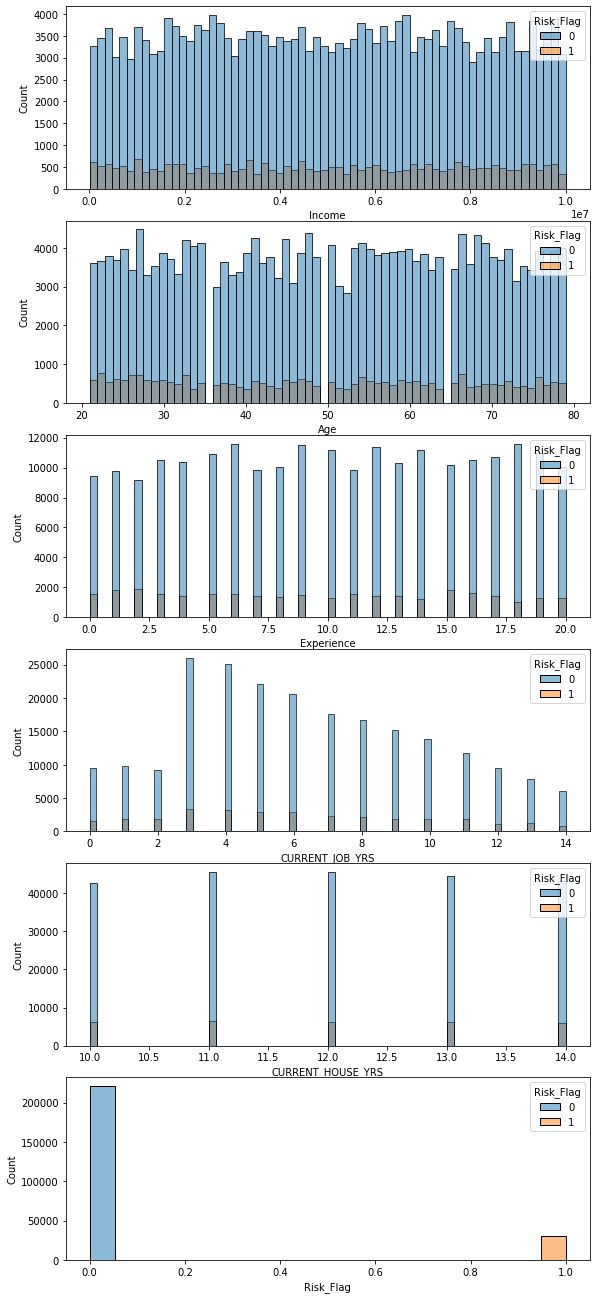

In [11]:
num_sub_plots_hist(train_num)

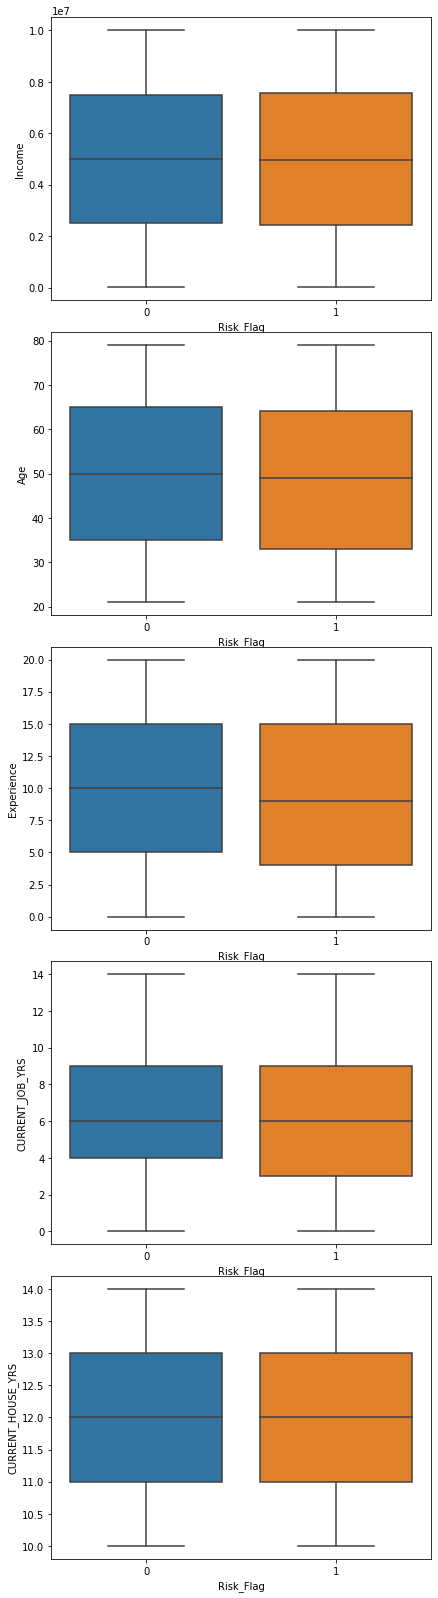

In [12]:
num_sub_plots_box(train_num)

**No single variabel stands out as having good seperation of the target variable, perhaps linear and polynomical combinations will heald some seperation**

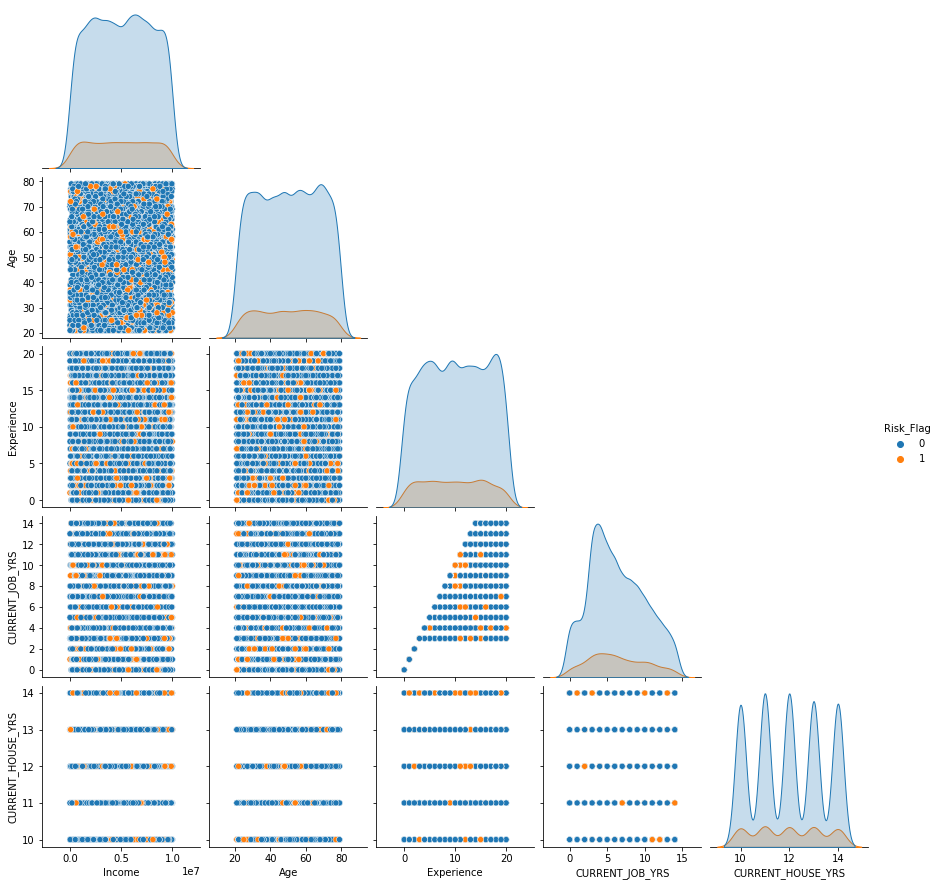

In [13]:
sns.pairplot(train_num.iloc[:10000,:], hue="Risk_Flag", corner=True);

**No clear linear combination of features shows good seperation of target variable**

#### Polynomial Combinations of Features

In [14]:
def names_for_poly_df(df):
    """
    Input: a numerical dataframe
    Output: returns a list of the polynomial feature column names in a more readable format
    """
    
    poly_cols = create_poly_df(df).columns
    poly_col_dic = {k:v for k,v in zip(poly_cols[:len(df.columns)-1], df.columns[:-1])}
    
    new_cols = []
    for col in poly_cols[:-1]:
        split_col_space = col.split(" ")
        temp_scol = []
        for scol in split_col_space:
            if len(split_col_space) > 1:
                temp_scol.append(scol.replace(scol[:2], poly_col_dic[scol[:2]]))
            else:
                new_cols.append(scol.replace(scol[:2], poly_col_dic[scol[:2]]))
        new_cols.append(" * ".join(temp_scol))
        
    names = [name for name in new_cols if name != ""]
    names.append("Risk_Flag")

    return names

In [15]:
def create_poly_df(df, poly=2):
    """
    Inputs: a numerical dataframe and number of polynomal features
    Output: a dataframe with polynomical feature combinations
    """
    
    polyclass = PolynomialFeatures(poly)
    train_poly = pd.DataFrame(data=polyclass.fit_transform(train_num.drop(labels="Risk_Flag", axis=1)),
                 columns=polyclass.get_feature_names(), index=train_num.index)
    if train_poly.columns[-1] != "Risk_Flag":
        train_poly = pd.concat([train_poly, train_num["Risk_Flag"]],axis=1).drop(labels="1", axis=1)
        
        
    return train_poly

In [16]:
create_poly_df(train_num).head()

,x0,x1,x2,x3,x4,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,...,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2,Risk_Flag
Id,,,,,,,,,,,,,,,,,,,,,
1,1303834.0,23.0,3.0,3.0,13.0,1.699983e+12,29988182.0,3911502.0,3911502.0,16949842.0,...,69.0,69.0,299.0,9.0,9.0,39.0,9.0,39.0,169.0,0
2,7574516.0,40.0,10.0,9.0,13.0,5.737329e+13,302980640.0,75745160.0,68170644.0,98468708.0,...,400.0,360.0,520.0,100.0,90.0,130.0,81.0,117.0,169.0,0
3,3991815.0,66.0,4.0,4.0,10.0,1.593459e+13,263459790.0,15967260.0,15967260.0,39918150.0,...,264.0,264.0,660.0,16.0,16.0,40.0,16.0,40.0,100.0,0
4,6256451.0,41.0,2.0,2.0,12.0,3.914318e+13,256514491.0,12512902.0,12512902.0,75077412.0,...,82.0,82.0,492.0,4.0,4.0,24.0,4.0,24.0,144.0,1
5,5768871.0,47.0,11.0,3.0,14.0,3.327987e+13,271136937.0,63457581.0,17306613.0,80764194.0,...,517.0,141.0,658.0,121.0,33.0,154.0,9.0,42.0,196.0,1


In [17]:
print(names_for_poly_df(train_num))

['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Income^2', 'Income * Age', 'Income * Experience', 'Income * CURRENT_JOB_YRS', 'Income * CURRENT_HOUSE_YRS', 'Age^2', 'Age * Experience', 'Age * CURRENT_JOB_YRS', 'Age * CURRENT_HOUSE_YRS', 'Experience^2', 'Experience * CURRENT_JOB_YRS', 'Experience * CURRENT_HOUSE_YRS', 'CURRENT_JOB_YRS^2', 'CURRENT_JOB_YRS * CURRENT_HOUSE_YRS', 'CURRENT_HOUSE_YRS^2', 'Risk_Flag']


In [18]:
test_df = create_poly_df(train_num)
test_df.columns = names_for_poly_df(train_num)
test_df.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Income^2,Income * Age,Income * Experience,Income * CURRENT_JOB_YRS,Income * CURRENT_HOUSE_YRS,...,Age * Experience,Age * CURRENT_JOB_YRS,Age * CURRENT_HOUSE_YRS,Experience^2,Experience * CURRENT_JOB_YRS,Experience * CURRENT_HOUSE_YRS,CURRENT_JOB_YRS^2,CURRENT_JOB_YRS * CURRENT_HOUSE_YRS,CURRENT_HOUSE_YRS^2,Risk_Flag
Id,,,,,,,,,,,,,,,,,,,,,
1,1303834.0,23.0,3.0,3.0,13.0,1.699983e+12,29988182.0,3911502.0,3911502.0,16949842.0,...,69.0,69.0,299.0,9.0,9.0,39.0,9.0,39.0,169.0,0
2,7574516.0,40.0,10.0,9.0,13.0,5.737329e+13,302980640.0,75745160.0,68170644.0,98468708.0,...,400.0,360.0,520.0,100.0,90.0,130.0,81.0,117.0,169.0,0
3,3991815.0,66.0,4.0,4.0,10.0,1.593459e+13,263459790.0,15967260.0,15967260.0,39918150.0,...,264.0,264.0,660.0,16.0,16.0,40.0,16.0,40.0,100.0,0
4,6256451.0,41.0,2.0,2.0,12.0,3.914318e+13,256514491.0,12512902.0,12512902.0,75077412.0,...,82.0,82.0,492.0,4.0,4.0,24.0,4.0,24.0,144.0,1
5,5768871.0,47.0,11.0,3.0,14.0,3.327987e+13,271136937.0,63457581.0,17306613.0,80764194.0,...,517.0,141.0,658.0,121.0,33.0,154.0,9.0,42.0,196.0,1


**Plotting polynomial feature combinations:**

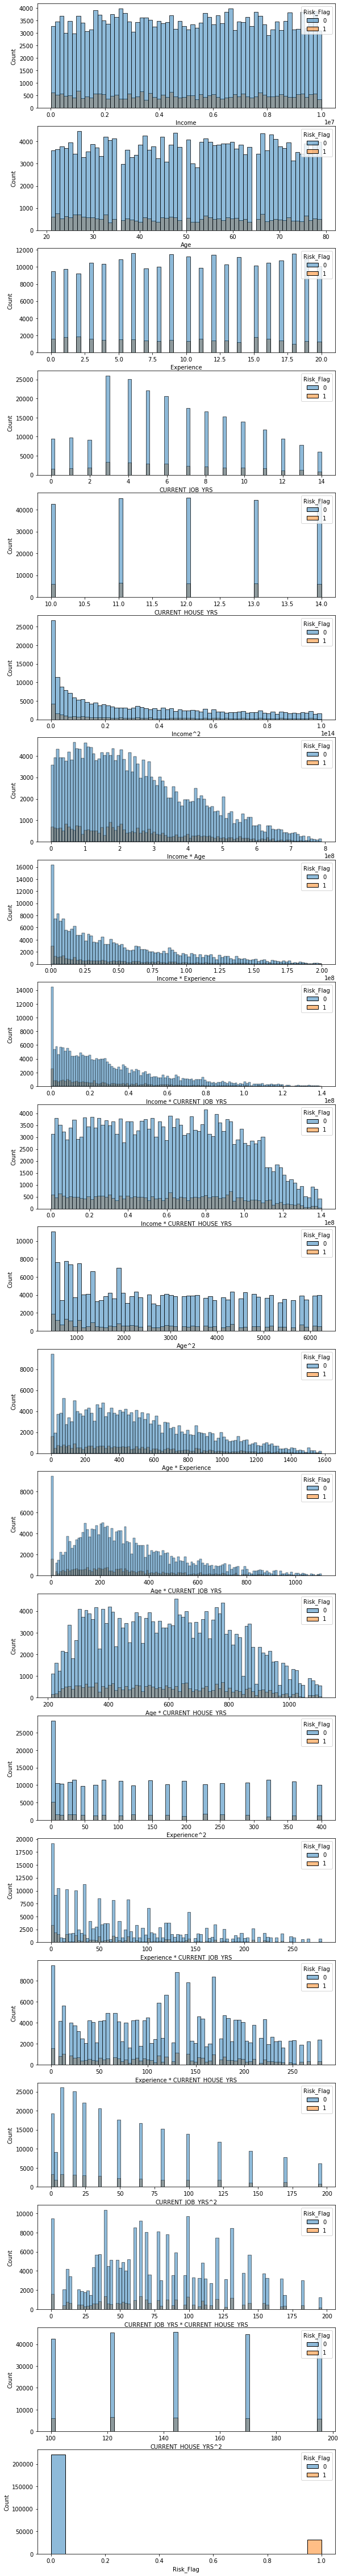

In [19]:
num_sub_plots_hist(test_df)

**Polynomical combinations dont seem to yeild better seperation either**

## Categorical Features:

In [20]:
train_cat = pd.concat([train_df.select_dtypes(include=["object"]), train_df["Risk_Flag"]], axis=1)
train_cat.head()

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Risk_Flag
0,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,0
1,single,rented,no,Software_Developer,Parbhani,Maharashtra,0
2,married,rented,no,Technical_writer,Alappuzha,Kerala,0
3,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,1
4,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,1


In [21]:
len(train_cat["STATE"].value_counts())

29

In [22]:
def plot_cat_features(feature_name, limit=5, ascending=False):
    """
    Input: Feature names, the total number of categoricals looked at, and the sorting prefered
    Output: returns a plot of the categoricals vs loan default, returns the highest percentage defaults
    """
    # creates a df of categorical as index and risk_flag as columns, the values are the total counts.
    group_risk = train_cat.groupby([feature_name,"Risk_Flag"])[feature_name].count().unstack()
    
    # loops through each row and updates the values as a percentage
    for row in group_risk.index:
        group_risk.loc[row] = group_risk.loc[row]/group_risk.loc[row].sum()
    
    # orders the values by highest percentage loan defaults first
    group_risk = group_risk.sort_values(by=1, ascending=ascending)[:limit]
    
    # plots the data as a bar plot
    group_risk.plot(kind="bar", figsize=(2*len(group_risk.index), 6))
    plt.title(f"{feature_name} Risk_Flag Count")
    plt.ylabel("Percentage");

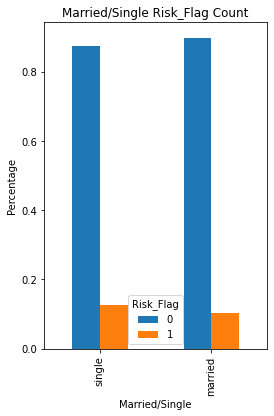

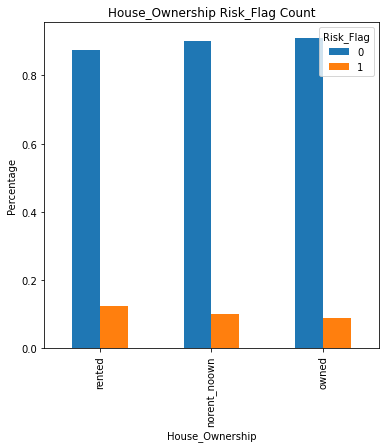

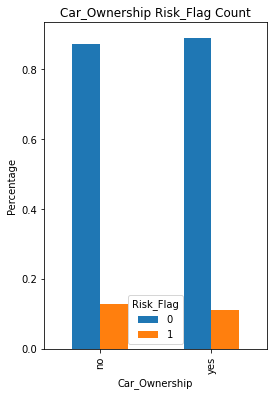

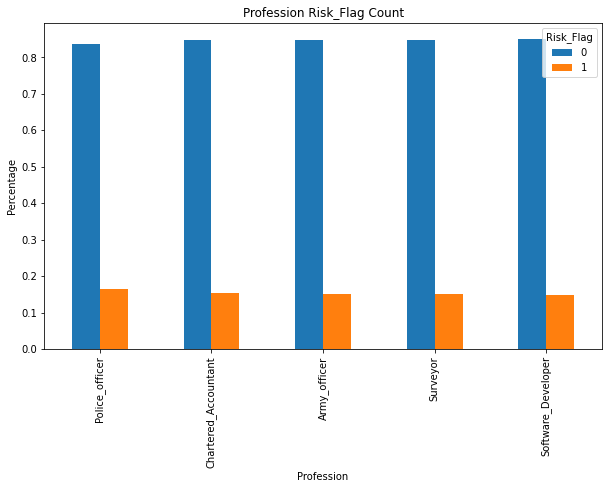

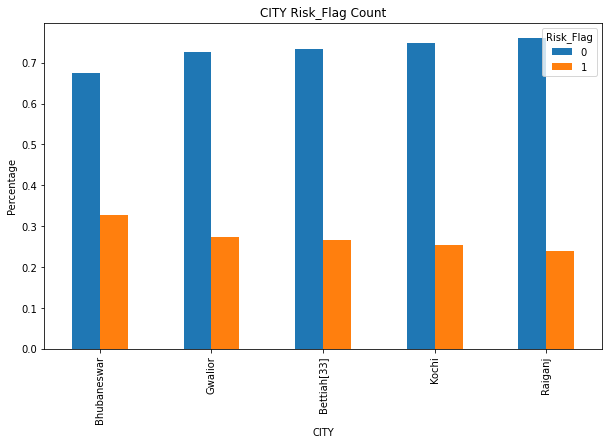

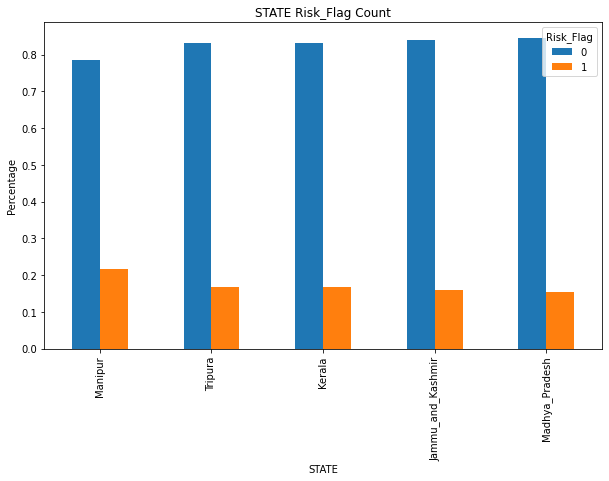

In [23]:
for col in train_cat.columns[:-1]:
    plot_cat_features(col)

In [24]:
train_cat[(train_cat["Married/Single"] == "single")
          & (train_cat["House_Ownership"] == "rented")
          & (train_cat["Car_Ownership"] == "no")
          & (train_cat["Profession"] == "Police_officer")
          & (train_cat["CITY"] == "Bhubaneswar")]["Risk_Flag"].value_counts()

0    46
1    29
Name: Risk_Flag, dtype: int64

**39%** of people who are singel, rent, dont have a car, are a police officer and live in Bhubaneswar make loan defaults!

In [25]:
mean_default = 100*train_cat["Risk_Flag"].value_counts().values[1]/train_cat["Risk_Flag"].value_counts().sum()
print("The mean default rate for this data is: {}%".format(mean_default))

The mean default rate for this data is: 12.3%


**According to the data the worst thing you could do for your loan application would be (in order of worst):**
- live in Bhubaneswar
- Be in the state of Manipur
- Be a police officer
- rent
- not have a car
- be single

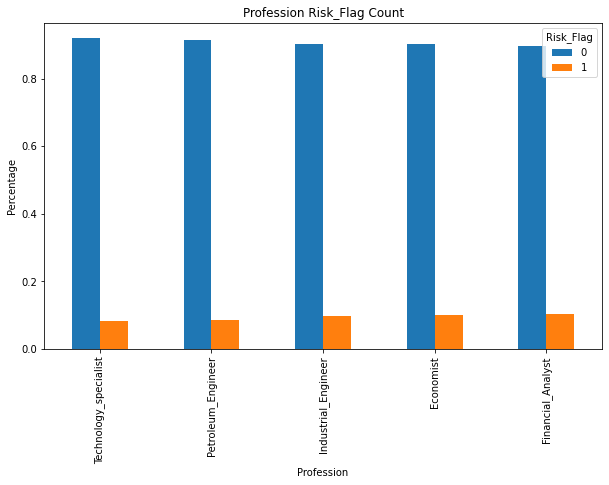

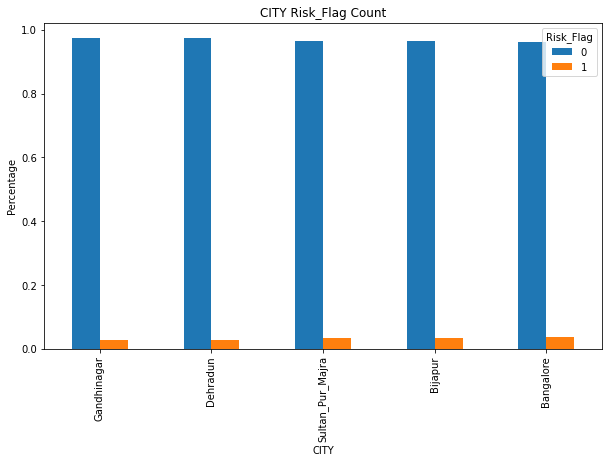

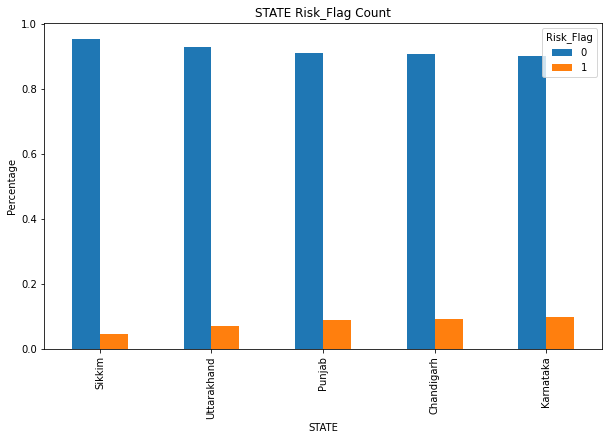

In [26]:
# shows the best proffesions, cities, and states to live in for loan defaults:

for col in train_cat.columns[-4:-1]:
    plot_cat_features(col, ascending=True)

## Transform Categorical Values into One Hot Encodings:

If i turned all the categoricals into columns my dataset would end up with 408 columns! At the moment it has 12.

**Group values in the Proffession, City, and State into bins to reduce number of columns**

In [27]:
print("Total number of unique professions: {}".format(train_cat["Profession"].nunique()))
print("Total number of unique cities: {}".format(train_cat["CITY"].nunique()))
print("Total number of unique states: {}".format(train_cat["STATE"].nunique()))

Total number of unique professions: 51
Total number of unique cities: 317
Total number of unique states: 29


**I will try changing the unique names to numbers where a low number shows a low Risk_Flag rate**

This will be done base on the above % Risk Flag for each unique value

**How**: First I need to create a dictionaries with keys as unique values and items as the relative risk_flag score for state, city, profession features.

I will then loop through the data set and use the dictionary to update the unique categorical values to these dictionary item values

In [28]:
# creates a df of categorical as index and risk_flag as columns, the values are the total counts.
def risk_flag_ranked_dictionary(df, feature):
    group_risk = df.groupby([feature,"Risk_Flag"])[feature].count().unstack()

    # loops through each row and updates the values as a percentage
    for row in group_risk.index:
        group_risk.loc[row] = group_risk.loc[row]/group_risk.loc[row].sum()

    # orders the values by highest percentage loan defaults first
    group_risk = group_risk.sort_values(by=1, ascending=True)
    group_risk["Risk_Rank"] = range(1,len(group_risk)+1)
    
    return group_risk["Risk_Rank"].to_dict()

In [29]:
# example of output:
risk_flag_ranked_dictionary(train_cat, "Profession")

{'Technology_specialist': 1,
 'Petroleum_Engineer': 2,
 'Industrial_Engineer': 3,
 'Economist': 4,
 'Financial_Analyst': 5,
 'Design_Engineer': 6,
 'Web_designer': 7,
 'Designer': 8,
 'Dentist': 9,
 'Mechanical_engineer': 10,
 'Chemical_engineer': 11,
 'Politician': 12,
 'Librarian': 13,
 'Drafter': 14,
 'Graphic_Designer': 15,
 'Fashion_Designer': 16,
 'Surgeon': 17,
 'Statistician': 18,
 'Civil_servant': 19,
 'Engineer': 20,
 'Physician': 21,
 'Comedian': 22,
 'Magistrate': 23,
 'Analyst': 24,
 'Chef': 25,
 'Psychologist': 26,
 'Artist': 27,
 'Flight_attendant': 28,
 'Computer_operator': 29,
 'Microbiologist': 30,
 'Consultant': 31,
 'Biomedical_Engineer': 32,
 'Technician': 33,
 'Computer_hardware_engineer': 34,
 'Lawyer': 35,
 'Secretary': 36,
 'Architect': 37,
 'Technical_writer': 38,
 'Aviator': 39,
 'Hotel_Manager': 40,
 'Air_traffic_controller': 41,
 'Firefighter': 42,
 'Official': 43,
 'Civil_engineer': 44,
 'Geologist': 45,
 'Scientist': 46,
 'Software_Developer': 47,
 'Surve

In [30]:
def transform_categorical_to_risk_rank(row, dic):
    return dic[row]

In [31]:
for feature in train_cat.columns[-4:-1]:
    dic = risk_flag_ranked_dictionary(train_cat, feature)
    train_cat[feature] = train_cat[feature].apply(lambda row: transform_categorical_to_risk_rank(row, dic))

In [32]:
train_cat.head()

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Risk_Flag
0,single,rented,no,10,166,25,0
1,single,rented,no,47,170,9,0
2,married,rented,no,38,193,27,0
3,single,rented,yes,47,317,24,1
4,single,rented,no,19,160,6,1


### One-hot encode the other features:

In [33]:
def features_to_one_hot(df):
    """
    Input: The categorical data frame.
    Output: The dataframe with one-hot encoded features, drop_first is used to remove redundant features and prevent
            multicollinearity. 
    """
    
    for feature in df.columns[0:3]:
        df = pd.concat([pd.get_dummies(df[feature], drop_first=True), df.drop(labels=feature,axis=1)],axis=1)
        
    return df

In [34]:
train_cat = features_to_one_hot(train_cat)
train_cat.head()

,yes,owned,rented,single,Profession,CITY,STATE,Risk_Flag
0,0,0,1,1,10,166,25,0
1,0,0,1,1,47,170,9,0
2,0,0,1,0,38,193,27,0
3,1,0,1,1,47,317,24,1
4,0,0,1,1,19,160,6,1


## Combine Datasets:

In [35]:
train_num.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,
1,1303834,23,3,3,13,0
2,7574516,40,10,9,13,0
3,3991815,66,4,4,10,0
4,6256451,41,2,2,12,1
5,5768871,47,11,3,14,1


In [36]:
train_cat.head()

,yes,owned,rented,single,Profession,CITY,STATE,Risk_Flag
0,0,0,1,1,10,166,25,0
1,0,0,1,1,47,170,9,0
2,0,0,1,0,38,193,27,0
3,1,0,1,1,47,317,24,1
4,0,0,1,1,19,160,6,1


In [37]:
def combine_dfs(df1, df2):
    if df1.index[0] > 0:
        df1.index -= 1 # fix index shift
    train_df = pd.concat([df1, df2], axis=1)
    new_col_names = [col.lower().capitalize() for col in train_df.columns]
    train_df.columns = new_col_names
    return train_df

In [38]:
combine_dfs(train_num, train_cat).head()

,Income,Age,Experience,Current_job_yrs,Current_house_yrs,Risk_flag,Yes,Owned,Rented,Single,Profession,City,State,Risk_flag
0,1303834,23,3,3,13,0,0,0,1,1,10,166,25,0
1,7574516,40,10,9,13,0,0,0,1,1,47,170,9,0
2,3991815,66,4,4,10,0,0,0,1,0,38,193,27,0
3,6256451,41,2,2,12,1,1,0,1,1,47,317,24,1
4,5768871,47,11,3,14,1,0,0,1,1,19,160,6,1


## Building DataPipeline for Train/Test Data

In [39]:
# this code repeats a lot from above, its just used to quickly pull the data from csv and have it in the correct format
# by running main()

def import_data(train=True):
    """
    Input: Bool asking for either train or test data to be returned
    Output: Either the training data or the test data
    """
    
    if train:
        return pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv")
    else:
        df_test = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv")
        df_test.rename(columns={"ID":"Id"}, inplace=True)
        targets = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv")
        targets.rename(columns={"id":"Id", "risk_flag":"Risk_Flag"}, inplace=True)
        
        return pd.concat([df_test,targets.drop("Id",axis=1)],axis=1)

    
def split_num_cat(df, num=True):
    """
    Input: the whole dataframe, if the user wants to return just the numerical to categorical features
    Output: Either a df with numerical features or categroical features
    """
    
    if num:
        return df.select_dtypes(include=["int64"]).set_index("Id")
    else:
        return pd.concat([df.select_dtypes(include=["object"]), df["Risk_Flag"]], axis=1)

    
def risk_flag_ranked_dictionary(df, feature):
    """
    Input: a categorical dataframe, the feature that is being ranked interms of risk flag
    Output: a dictionary of the unique categorical values, with items as the relative risk
    """
    
    group_risk = df.groupby([feature,"Risk_Flag"])[feature].count().unstack()

    # loops through each row and updates the values as a percentage
    for row in group_risk.index:
        group_risk.loc[row] = group_risk.loc[row]/group_risk.loc[row].sum()

    # orders the values by highest percentage loan defaults first
    group_risk = group_risk.sort_values(by=1, ascending=True)
    group_risk["Risk_Rank"] = range(1,len(group_risk)+1)
    
    return group_risk["Risk_Rank"].to_dict()


def transform_categorical_to_risk_rank(row, dic):
    """
    Input: the row of the dataframe, the dictionary from risk_flag_ranked_dictionary for a feature
    Output: updates the dataframes unique values with relative risk rankings
    """
    
    return dic[row]


def cat_to_num(df):
    """
    Input: 
    """
    for feature in df.columns[-4:-1]:
        dic = risk_flag_ranked_dictionary(df, feature)
        df[feature] = df[feature].apply(lambda row: transform_categorical_to_risk_rank(row, dic))
        
    return df.drop("Risk_Flag", axis=1)
        
    
def features_to_one_hot(df):
    """
    Input: The categorical data frame.
    Output: The dataframe with one-hot encoded features, drop_first is used to remove redundant features and prevent
            multicollinearity. 
    """
    
    for feature in df.columns[0:3]:
        df = pd.concat([pd.get_dummies(df[feature], drop_first=True), df.drop(labels=feature,axis=1)], axis=1)
        
    return df


def combine_dfs(df_num, df_cat):
    """
    Input: both the numerical and categorical dataframes
    Output: Both dataframes concatenated into one
    """
    
    if df_num.index[0] > 0:
        df_num.index -= 1 # fix index shift
    train_df = pd.concat([df_num, df_cat], axis=1)
    new_col_names = [col.lower().capitalize() for col in train_df.columns]
    train_df.columns = new_col_names
    
    return train_df


def main(train=True):
    """
    Input: train - used as a control flow for users to either return train or test datasets
    Ouput: takes a raw csv data and returns a dataframe read for ML
    """
    
    if train:
        df = import_data(train=train)
    else:
        df = import_data(train=False)
    df_num = split_num_cat(df)
    df_cat = split_num_cat(df, num=False)
    df_cat = cat_to_num(df_cat)
    df_cat = features_to_one_hot(df_cat)
    df = combine_dfs(df_num, df_cat)
    
    return df

In [40]:
test_df = main(train=False)
test_df.head()

,Income,Age,Experience,Current_job_yrs,Current_house_yrs,Risk_flag,Yes,Owned,Rented,Single,Profession,City,State
0,7393090,59,19,4,13,0,0,0,1,1,26,35,7
1,1215004,25,5,5,10,0,0,0,1,1,3,278,10
2,8901342,50,12,9,14,1,0,0,1,1,32,107,10
3,1944421,49,9,3,12,0,1,0,1,0,1,288,10
4,13429,25,18,13,11,0,1,0,1,1,45,221,7


In [41]:
train_df = main()
train_df.head()

,Income,Age,Experience,Current_job_yrs,Current_house_yrs,Risk_flag,Yes,Owned,Rented,Single,Profession,City,State
0,1303834,23,3,3,13,0,0,0,1,1,10,166,25
1,7574516,40,10,9,13,0,0,0,1,1,47,170,9
2,3991815,66,4,4,10,0,0,0,1,0,38,193,27
3,6256451,41,2,2,12,1,1,0,1,1,47,317,24
4,5768871,47,11,3,14,1,0,0,1,1,19,160,6


## Machine Learning Section:

In [42]:
# split train into train-validation
# split test into X,y
# scale data
# run initial models
# evaluate models, including tests for bias/variance
# error analysis on best model
# possible more feature analysis
# final model

#### Train Validation Test Split:

In [43]:
X = train_df.drop("Risk_flag", axis=1)
y = train_df["Risk_flag"]
X_test = test_df.drop("Risk_flag", axis=1)
y_test = test_df["Risk_flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (176400, 12)
X_val shape: (75600, 12)
X_test shape: (28000, 12)


#### Scaling Data

In [44]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Models:

In [45]:
def evaluate(model, train=False, val=False, test=False):
    # returns train results    
    if train == True:
        name = model
        pred = model.predict(X_train)
        plt.figure(figsize=(4,4))
        sns.heatmap(confusion_matrix(y_train, pred),
                    annot=True, fmt='g', cmap="BuGn", cbar=False)

        plt.xlabel("Predicted Values", fontsize=14)
        plt.ylabel("True Values", fontsize=14)
        plt.title("Confusion Matrix Train", fontsize=18);
        print("-----------------------TRAINING SCORES-----------------------")
        print("")
        print(str(model)+" accuracy score: {:.2f}".format(accuracy_score(y_train, pred)))
        print(str(model)+" precision score: {:.2f}".format(precision_score(y_train, pred, zero_division=0)))
        print(str(model)+" recall score: {:.2f}".format(recall_score(y_train, pred)))
        print("")
        
    # returns val results
    if val == True:
        name = model
        pred = model.predict(X_val)
        plt.figure(figsize=(4,4))
        sns.heatmap(confusion_matrix(y_val, pred),
                    annot=True, fmt='g', cmap="BuGn", cbar=False)

        plt.xlabel("Predicted Values", fontsize=14)
        plt.ylabel("True Values", fontsize=14)
        plt.title("Confusion Matrix Val", fontsize=18);
        print("----------------------VALIDATION SCORES---------------------")
        print("")
        print(str(model)+" accuracy score: {:.2f}".format(accuracy_score(y_val, pred)))
        print(str(model)+" precision score: {:.2f}".format(precision_score(y_val, pred, zero_division=0)))
        print(str(model)+" recall score: {:.2f}".format(recall_score(y_val, pred)))
        print("")
        
    # completely unseen data
    if test == True:
        name = model
        pred = model.predict(X_test)
        plt.figure(figsize=(4,4))
        sns.heatmap(confusion_matrix(y_test, pred),
                    annot=True, fmt='g', cmap="BuGn", cbar=False)

        plt.xlabel("Predicted Values", fontsize=14)
        plt.ylabel("True Values", fontsize=14)
        plt.title("Confusion Matrix Test", fontsize=18);
        print("-------------------------TEST SCORES-----------------------")
        print("")
        print(str(model)+" accuracy score: {:.2f}".format(accuracy_score(y_test, pred)))
        print(str(model)+" precision score: {:.2f}".format(precision_score(y_test, pred, zero_division=0)))
        print(str(model)+" recall score: {:.2f}".format(recall_score(y_test, pred)))

-----------------------TRAINING SCORES-----------------------

LogisticRegression() accuracy score: 0.88
LogisticRegression() precision score: 0.00
LogisticRegression() recall score: 0.00

----------------------VALIDATION SCORES---------------------

LogisticRegression() accuracy score: 0.88
LogisticRegression() precision score: 0.00
LogisticRegression() recall score: 0.00



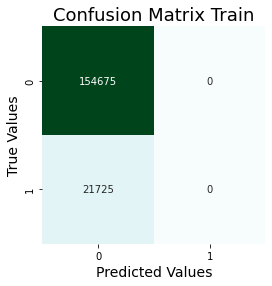

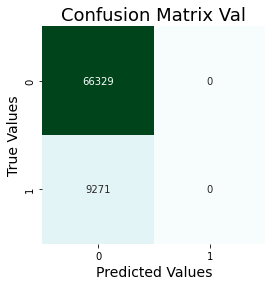

In [46]:
clf_lr = LogisticRegression().fit(X_train, y_train)
evaluate(clf_lr, train = True, val = True)

-----------------------TRAINING SCORES-----------------------

RandomForestClassifier() accuracy score: 0.94
RandomForestClassifier() precision score: 0.72
RandomForestClassifier() recall score: 0.81

----------------------VALIDATION SCORES---------------------

RandomForestClassifier() accuracy score: 0.90
RandomForestClassifier() precision score: 0.60
RandomForestClassifier() recall score: 0.55



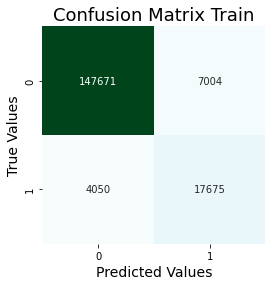

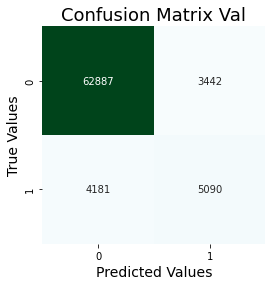

In [47]:
clf_rf = RandomForestClassifier().fit(X_train, y_train)
evaluate(clf_rf, train=True, val=True)

-----------------------TRAINING SCORES-----------------------

GaussianNB() accuracy score: 0.88
GaussianNB() precision score: 0.00
GaussianNB() recall score: 0.00

----------------------VALIDATION SCORES---------------------

GaussianNB() accuracy score: 0.88
GaussianNB() precision score: 0.00
GaussianNB() recall score: 0.00



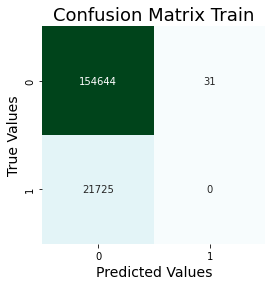

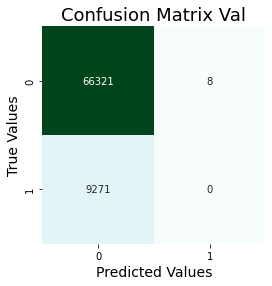

In [48]:
clf_gnb = GaussianNB().fit(X_train, y_train)
evaluate(clf_gnb, train=True, val=True)

-----------------------TRAINING SCORES-----------------------

KNeighborsClassifier() accuracy score: 0.90
KNeighborsClassifier() precision score: 0.61
KNeighborsClassifier() recall score: 0.53

----------------------VALIDATION SCORES---------------------

KNeighborsClassifier() accuracy score: 0.89
KNeighborsClassifier() precision score: 0.55
KNeighborsClassifier() recall score: 0.51



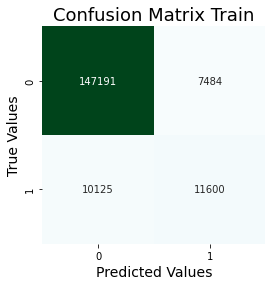

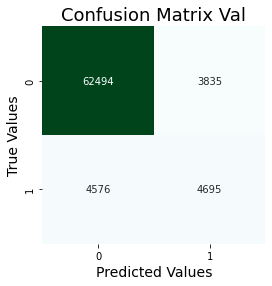

In [49]:
clf_knn = KNeighborsClassifier().fit(X_train, y_train)
evaluate(clf_knn, train=True, val=True)

-----------------------TRAINING SCORES-----------------------

AdaBoostClassifier() accuracy score: 0.88
AdaBoostClassifier() precision score: 0.83
AdaBoostClassifier() recall score: 0.00

----------------------VALIDATION SCORES---------------------

AdaBoostClassifier() accuracy score: 0.88
AdaBoostClassifier() precision score: 0.79
AdaBoostClassifier() recall score: 0.00



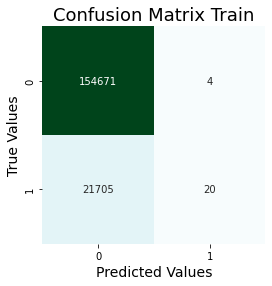

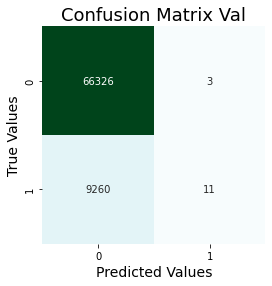

In [50]:
clf_adb = AdaBoostClassifier().fit(X_train, y_train)
evaluate(clf_adb, train=True, val=True)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-----------------------TRAINING SCORES-----------------------

MLPClassifier(hidden_layer_sizes=(64, 64, 64, 64, 64, 32), max_iter=100) accuracy score: 0.91
MLPClassifier(hidden_layer_sizes=(64, 64, 64, 64, 64, 32), max_iter=100) precision score: 0.63
MLPClassifier(hidden_layer_sizes=(64, 64, 64, 64, 64, 32), max_iter=100) recall score: 0.71

----------------------VALIDATION SCORES---------------------

MLPClassifier(hidden_layer_sizes=(64, 64, 64, 64, 64, 32), max_iter=100) accuracy score: 0.89
MLPClassifier(hidden_layer_sizes=(64, 64, 64, 64, 64, 32), max_iter=100) precision score: 0.53
MLPClassifier(hidden_layer_sizes=(64, 64, 64, 64, 64, 32), max_iter=100) recall score: 0.59



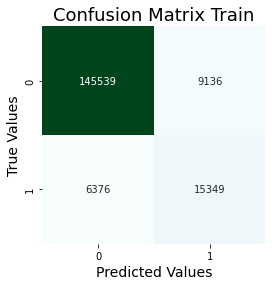

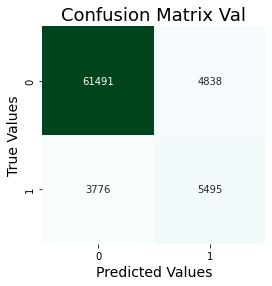

In [51]:
clf_nn = MLPClassifier(hidden_layer_sizes=(64,64,64,64,64,32), max_iter=100).fit(X_train,y_train)
evaluate(clf_nn, train=True, val=True)

**The best model seems to be the RandomForestClassifier, however, as per usualy with RFs it has some overtraining/variance problems**

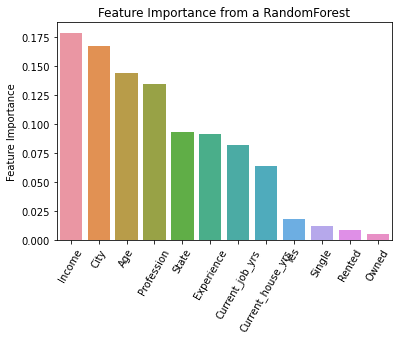

In [52]:
feature_importance = pd.Series(data=clf_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_importance.index, y=feature_importance.values)
plt.ylabel("Feature Importance")
plt.title("Feature Importance from a RandomForest")
plt.xticks(rotation='60');

### Error Analysis

In [53]:
pred = clf_rf.predict(X_val)

In [54]:
error_df = pd.DataFrame({"Predicted Value": pred, "True Value": y_val})

def error(row):
    if row[0] == 0 and row[1] == 1:
        return 1
    if row[0] == 1 and row[1] == 0:
        return 1

error_df["Check"] = error_df.apply(lambda row: error(row), axis=1)

In [55]:
error_df.head()

,Predicted Value,True Value,Check
75255,0,0,NaN
192435,0,0,NaN
154839,0,0,NaN
59774,0,0,NaN
63788,0,0,NaN


In [56]:
all_error = error_df[error_df.Check == 1]
all_error.head()

,Predicted Value,True Value,Check
226261,0,1,1.0
51260,0,1,1.0
190640,1,0,1.0
67022,0,1,1.0
104220,1,0,1.0


In [57]:
# all the data that the model predicted incorrect on (validation set only)!

val_error_df = train_df.loc[all_error.index,:]
val_error_df.rename(columns={"Risk_flag":"Risk_Flag"}, inplace =True)
val_error_df.head()

,Income,Age,Experience,Current_job_yrs,Current_house_yrs,Risk_Flag,Yes,Owned,Rented,Single,Profession,City,State
226261,8935440,29,13,5,12,1,1,0,1,0,1,283,15
51260,431500,51,10,10,11,1,1,0,1,1,48,271,9
190640,7571977,75,5,5,13,0,1,0,1,1,19,225,22
67022,4012270,39,7,7,10,1,1,0,1,1,7,294,22
104220,4499377,48,11,11,12,0,0,0,1,1,47,272,18


**Note: Error analysis takes a long time... I will not be pursuing it this time**

## GridSearch on RandomForest

In [58]:
## Random Forest:
#
#from sklearn.model_selection import cross_val_score, GridSearchCV
#
#grid = {"n_estimators": [10,50,100,300,600,1000],
#       "max_depth":[3,5,10,30,None]}
#
#grid_rf_model = GridSearchCV(RandomForestClassifier(), param_grid = grid, n_jobs=-2)
#grid_rf_model.fit(X_train, y_train)
#
#params_rf = grid_rf_model.best_params_
#
#rf_best_model = RandomForestClassifier(n_estimators=params_rf["n_estimators"], max_depth=params_rf["max_depth"])
#
#cross_val_score_rf_best = cross_val_score(rf_best_model, X, y, cv=5, n_jobs=-2)

In [59]:
# the grid search above takes a long time, the below was the best found model.
rf_best_model = RandomForestClassifier(n_estimators=50, max_depth=None)

-----------------------TRAINING SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.94
RandomForestClassifier(n_estimators=50) precision score: 0.72
RandomForestClassifier(n_estimators=50) recall score: 0.81

----------------------VALIDATION SCORES---------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.90
RandomForestClassifier(n_estimators=50) precision score: 0.60
RandomForestClassifier(n_estimators=50) recall score: 0.55

-------------------------TEST SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.87
RandomForestClassifier(n_estimators=50) precision score: 0.14
RandomForestClassifier(n_estimators=50) recall score: 0.00


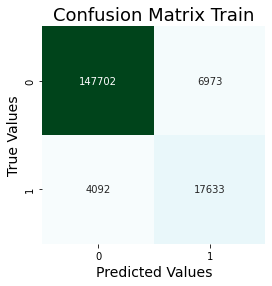

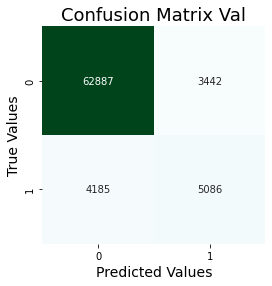

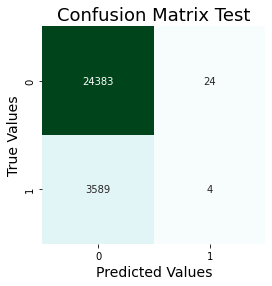

In [60]:
rf_best_model.fit(X_train, y_train)
evaluate(rf_best_model, train = True, val= True, test= True)

-----------------------TRAINING SCORES-----------------------

RandomForestClassifier() accuracy score: 0.94
RandomForestClassifier() precision score: 0.72
RandomForestClassifier() recall score: 0.81

----------------------VALIDATION SCORES---------------------

RandomForestClassifier() accuracy score: 0.90
RandomForestClassifier() precision score: 0.60
RandomForestClassifier() recall score: 0.55

-------------------------TEST SCORES-----------------------

RandomForestClassifier() accuracy score: 0.87
RandomForestClassifier() precision score: 0.00
RandomForestClassifier() recall score: 0.00


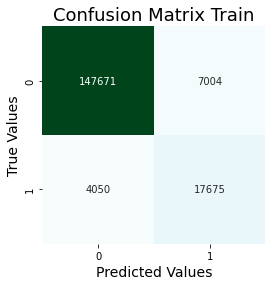

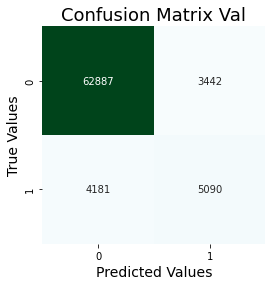

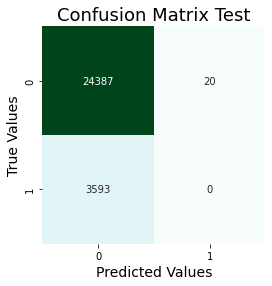

In [61]:
evaluate(clf_rf, train=True, val=True, test=True)

## Review:

**The model performas poorly on unseen data**

- The best metrics for this data would be either recall or precision (f1 score for a balance between the two)
- All models show high variance for precision and recall.
- High precision could be fixed by getting more data, trying a smaller set of features, increasing regularization (where possible).

#### Trying a larger training set:

In [62]:
X = train_df.drop("Risk_flag", axis=1)
y = train_df["Risk_flag"]
X_test = test_df.drop("Risk_flag", axis=1)
y_test = test_df["Risk_flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train shape: (226800, 12)
X_val shape: (25200, 12)
X_test shape: (28000, 12)


-----------------------TRAINING SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.94
RandomForestClassifier(n_estimators=50) precision score: 0.72
RandomForestClassifier(n_estimators=50) recall score: 0.79

----------------------VALIDATION SCORES---------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.90
RandomForestClassifier(n_estimators=50) precision score: 0.60
RandomForestClassifier(n_estimators=50) recall score: 0.53

-------------------------TEST SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.87
RandomForestClassifier(n_estimators=50) precision score: 0.09
RandomForestClassifier(n_estimators=50) recall score: 0.00


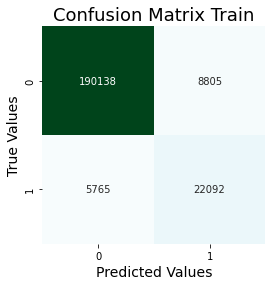

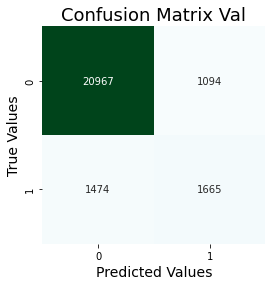

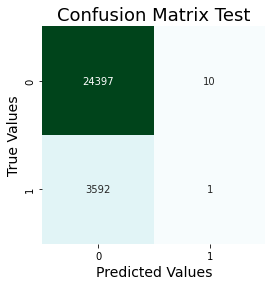

In [63]:
rf_best_model.fit(X_train, y_train)
evaluate(rf_best_model, train = True, val= True, test= True)

**No difference**

#### Try less features:

In [64]:
train_df = main()
test_df = main(train=False)

top_5_features = list(feature_importance.index[:1])
top_5_features.append("Risk_flag")
train_df = train_df[top_5_features]
test_df = test_df[top_5_features]

X = train_df.drop("Risk_flag", axis=1)
y = train_df["Risk_flag"]
X_test = test_df.drop("Risk_flag", axis=1)
y_test = test_df["Risk_flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train shape: (226800, 1)
X_val shape: (25200, 1)
X_test shape: (28000, 1)


-----------------------TRAINING SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.94
RandomForestClassifier(n_estimators=50) precision score: 0.71
RandomForestClassifier(n_estimators=50) recall score: 0.79

----------------------VALIDATION SCORES---------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.88
RandomForestClassifier(n_estimators=50) precision score: 0.53
RandomForestClassifier(n_estimators=50) recall score: 0.57

-------------------------TEST SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.77
RandomForestClassifier(n_estimators=50) precision score: 0.12
RandomForestClassifier(n_estimators=50) recall score: 0.13


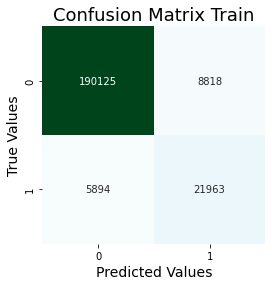

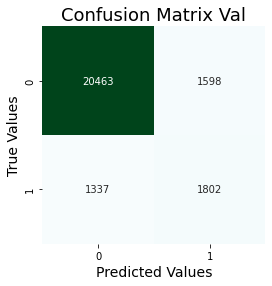

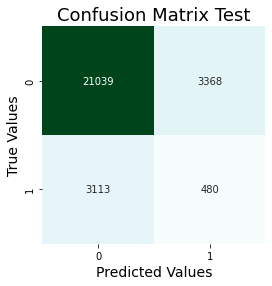

In [65]:
rf_best_model.fit(X_train, y_train)
evaluate(rf_best_model, train = True, val= True, test= True)

**small improvement when only using 2 features (income and city)**

### Try more Features...

In [66]:
X_poly2 = create_poly_df(X)
X_poly2.head()

,x0,x1,x2,x3,x4,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,...,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2,Risk_Flag
Id,,,,,,,,,,,,,,,,,,,,,
0,1303834.0,23.0,3.0,3.0,13.0,1.699983e+12,29988182.0,3911502.0,3911502.0,16949842.0,...,69.0,69.0,299.0,9.0,9.0,39.0,9.0,39.0,169.0,0
1,7574516.0,40.0,10.0,9.0,13.0,5.737329e+13,302980640.0,75745160.0,68170644.0,98468708.0,...,400.0,360.0,520.0,100.0,90.0,130.0,81.0,117.0,169.0,0
2,3991815.0,66.0,4.0,4.0,10.0,1.593459e+13,263459790.0,15967260.0,15967260.0,39918150.0,...,264.0,264.0,660.0,16.0,16.0,40.0,16.0,40.0,100.0,0
3,6256451.0,41.0,2.0,2.0,12.0,3.914318e+13,256514491.0,12512902.0,12512902.0,75077412.0,...,82.0,82.0,492.0,4.0,4.0,24.0,4.0,24.0,144.0,1
4,5768871.0,47.0,11.0,3.0,14.0,3.327987e+13,271136937.0,63457581.0,17306613.0,80764194.0,...,517.0,141.0,658.0,121.0,33.0,154.0,9.0,42.0,196.0,1


In [67]:
train_df = create_poly_df(main())
test_df = create_poly_df(main(train=False))
test_df.head()

,x0,x1,x2,x3,x4,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,...,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2,Risk_Flag
Id,,,,,,,,,,,,,,,,,,,,,
0,1303834.0,23.0,3.0,3.0,13.0,1.699983e+12,29988182.0,3911502.0,3911502.0,16949842.0,...,69.0,69.0,299.0,9.0,9.0,39.0,9.0,39.0,169.0,0
1,7574516.0,40.0,10.0,9.0,13.0,5.737329e+13,302980640.0,75745160.0,68170644.0,98468708.0,...,400.0,360.0,520.0,100.0,90.0,130.0,81.0,117.0,169.0,0
2,3991815.0,66.0,4.0,4.0,10.0,1.593459e+13,263459790.0,15967260.0,15967260.0,39918150.0,...,264.0,264.0,660.0,16.0,16.0,40.0,16.0,40.0,100.0,0
3,6256451.0,41.0,2.0,2.0,12.0,3.914318e+13,256514491.0,12512902.0,12512902.0,75077412.0,...,82.0,82.0,492.0,4.0,4.0,24.0,4.0,24.0,144.0,1
4,5768871.0,47.0,11.0,3.0,14.0,3.327987e+13,271136937.0,63457581.0,17306613.0,80764194.0,...,517.0,141.0,658.0,121.0,33.0,154.0,9.0,42.0,196.0,1


In [68]:
train_df.head()

,x0,x1,x2,x3,x4,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,...,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2,Risk_Flag
Id,,,,,,,,,,,,,,,,,,,,,
0,1303834.0,23.0,3.0,3.0,13.0,1.699983e+12,29988182.0,3911502.0,3911502.0,16949842.0,...,69.0,69.0,299.0,9.0,9.0,39.0,9.0,39.0,169.0,0
1,7574516.0,40.0,10.0,9.0,13.0,5.737329e+13,302980640.0,75745160.0,68170644.0,98468708.0,...,400.0,360.0,520.0,100.0,90.0,130.0,81.0,117.0,169.0,0
2,3991815.0,66.0,4.0,4.0,10.0,1.593459e+13,263459790.0,15967260.0,15967260.0,39918150.0,...,264.0,264.0,660.0,16.0,16.0,40.0,16.0,40.0,100.0,0
3,6256451.0,41.0,2.0,2.0,12.0,3.914318e+13,256514491.0,12512902.0,12512902.0,75077412.0,...,82.0,82.0,492.0,4.0,4.0,24.0,4.0,24.0,144.0,1
4,5768871.0,47.0,11.0,3.0,14.0,3.327987e+13,271136937.0,63457581.0,17306613.0,80764194.0,...,517.0,141.0,658.0,121.0,33.0,154.0,9.0,42.0,196.0,1


In [69]:
train_df = create_poly_df(main())
test_df = create_poly_df(main(train=False))

X = train_df.drop("Risk_Flag", axis=1)
y = train_df["Risk_Flag"]
X_test = test_df.drop("Risk_Flag", axis=1)
y_test = test_df["Risk_Flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train shape: (226800, 20)
X_val shape: (25200, 20)
X_test shape: (252000, 20)


-----------------------TRAINING SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.94
RandomForestClassifier(n_estimators=50) precision score: 0.71
RandomForestClassifier(n_estimators=50) recall score: 0.79

----------------------VALIDATION SCORES---------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.90
RandomForestClassifier(n_estimators=50) precision score: 0.59
RandomForestClassifier(n_estimators=50) recall score: 0.54

-------------------------TEST SCORES-----------------------

RandomForestClassifier(n_estimators=50) accuracy score: 0.93
RandomForestClassifier(n_estimators=50) precision score: 0.70
RandomForestClassifier(n_estimators=50) recall score: 0.77


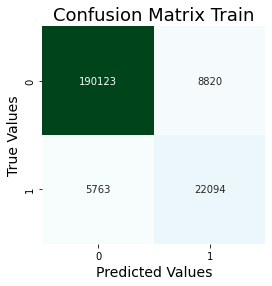

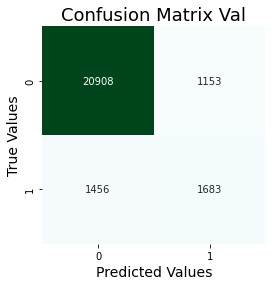

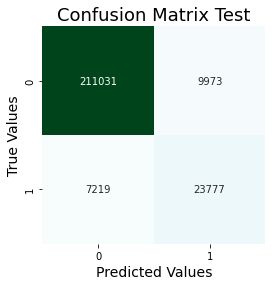

In [70]:
rf_best_model.fit(X_train, y_train)
evaluate(rf_best_model, train = True, val= True, test= True)

**Adding in Polynomial Features improved Test Score Performance massively!**